This file includes 

- select optimal $\kappa$ and save the results

- output example datasets


(**I consider selection in this file**)

In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat,savemat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
from scipy import signal
from tqdm import tqdm
import pickle
import seaborn as sns
%matplotlib inline

In [3]:
from pyTVDN.utils import load_pkl, save_pkl

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD/")
resDir = Path("./results")
dataDir = Path("./data")

In [6]:
with open("./OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

## Find the optimal kappa by Ctrl group

In [8]:
fil = list(resDir.glob("Ctrl_*_tuningNum.pkl"))[0]
with open(fil, "rb") as f:
    nchgAll = pickle.load(f)

In [9]:
nchgsMeans = [np.array(detObjNum).mean(axis=0) for detObjNum, kp in zip(nchgAll, kpCtrl) if kp!=0]
nchgsVars = [np.array(detObjNum).var(axis=0) for detObjNum, kp in zip(nchgAll, kpCtrl) if kp != 0]

In [10]:
kps = np.linspace(1, 4, 1000)
nchgsMM = np.array(nchgsMeans).mean(axis=0)
nchgsVarM = np.array(nchgsVars).mean(axis=0)
idxs = np.bitwise_and(nchgsMM >=3.0, nchgsMM <=19)
optIdx = np.where(idxs)[0][0] + np.where((nchgsVarM[idxs].min() == nchgsVarM)[idxs])[0][-1]

In [11]:
optKp = kps[optIdx]

In [12]:
print(optKp, nchgsMM[optIdx])

2.8528528528528527 3.3045454545454547


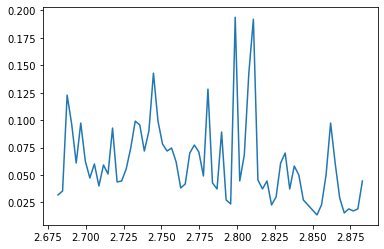

In [13]:
idxs = np.bitwise_and(nchgsMM >=2.5, nchgsMM <=10)
plt.plot(kps[idxs], nchgsVarM[idxs])

## Update kappa and save the results for both groups

In [14]:
print(optKp)

2.8528528528528527


### Save ecpts under optimal Kappa

In [33]:
ecptss = []
ps = list(resDir.glob("Ctrl_*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    ecptss.append(det.ecpts)
filName = f"Ctrl_data_lamb{det.paras.lamb:.1E}_ecpts.pkl"
with open(resDir/filName, "wb") as f:
    pickle.dump(ecptss, f)

100%|██████████| 92/92 [02:17<00:00,  1.50s/it]


In [ ]:
ecptss = []
ps = list(resDir.glob("ADfalp_*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    ecptss.append(det.ecpts)
filName = f"ADfalp_data_lamb{det.paras.lamb:.1E}_ecpts.pkl"
with open(resDir/filName, "wb") as f:
    pickle.dump(ecptss, f)

 32%|███▏      | 28/88 [00:39<01:24,  1.42s/it]

### Save eigVecs and eigVals under optimal Kappa

In [ ]:
def GetFeatures(det):
    """
    obtain the eigvals and eigvectors for current ecpts
    """
    if det.RecResCur is None:
        det.GetRecResCur()
    Ur = det.midRes.eigVecs[:, :det.paras.r]
        
    lamMs = []
    for idx, ecpt in enumerate(np.concatenate([[0], det.ecpts])):
        lamM = det.RecResCur.LamMs[:, int(ecpt)]
        lamMs.append(lamM)
    
    det.curEigVecs = Ur
    det.curEigVals = lamMs

In [36]:
eigVecss = []
eigValss = []
ps = list(resDir.glob("Ctrlfalp_*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    GetFeatures(det)
    eigVecss.append(det.curEigVecs)
    eigValss.append(det.curEigVals)
filNameVecs = f"Ctrlfalp_data_lamb{det.paras.lamb:.1E}_eigVecs.pkl"
filNameVals = f"Ctrlfalp_data_lamb{det.paras.lamb:.1E}_eigVals.pkl"
with open(resDir/filNameVecs, "wb") as f:
    pickle.dump(eigVecss, f)
with open(resDir/filNameVals, "wb") as f:
    pickle.dump(eigValss, f)

100%|██████████| 92/92 [02:14<00:00,  1.47s/it]


In [37]:
eigVecss = []
eigValss = []
ps = list(resDir.glob("ADfalp_*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for fil in tqdm(sortedPs):
    with open(fil, "rb") as f:
        det = pickle.load(f)
    det.UpdateEcpts(det.numchgs[kps==optKp][0])
    GetFeatures(det)
    eigVecss.append(det.curEigVecs)
    eigValss.append(det.curEigVals)
filNameVecs = f"ADfalp_data_lamb{det.paras.lamb:.1E}_eigVecs.pkl"
filNameVals = f"ADfalp_data_lamb{det.paras.lamb:.1E}_eigVals.pkl"
with open(resDir/filNameVecs, "wb") as f:
    pickle.dump(eigVecss, f)
with open(resDir/filNameVals, "wb") as f:
    pickle.dump(eigValss, f)

100%|██████████| 88/88 [02:05<00:00,  1.42s/it]


### Save smoothed data in `mat` format

In [255]:
XmatsCtrl = {}
ps = list(resDir.glob("Ctrl_*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
flag = 0
for fil in tqdm(sortedPs):
    det = load_pkl(fil)
    XmatsCtrl[f"dat{flag}"] = det.Xmat
    flag += 1
filNameXmats = f"Ctrl_data_lamb{det.paras.lamb:.1E}_Xmats.mat"
savemat(resDir/filNameXmats, XmatsCtrl)

100%|██████████| 92/92 [02:40<00:00,  1.74s/it]


In [256]:
XmatsAD = {}
ps = list(resDir.glob("ADf_*04_decimate5.pkl"))
sortedPs = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
flag = 0
for fil in tqdm(sortedPs):
    det = load_pkl(fil)
    XmatsAD[f"dat{flag}"] = det.Xmat
    flag += 1
filNameXmats = f"ADf_data_lamb{det.paras.lamb:.1E}_Xmats.mat"
savemat(resDir/filNameXmats, XmatsAD)

100%|██████████| 88/88 [02:45<00:00,  1.88s/it]


## Save `Xmat` and `nYmat` 

- `Xmat`: data after smoothing
- `nYmat`: data before smoothing but after detrending and decimating

Note I only keep the samples in the subsequent analysis

In [54]:
def _extract_maxdwell(dwells, ecpts, mat):
    idx = np.argmax(dwells)
    assert mat.shape[1] == 7200 or mat.shape[1]==36000
    if len(ecpts)==0 or ecpts[0] != 0:
        ecpts = np.concatenate([[0], ecpts, [mat.shape[1]]])
    low, up = int(ecpts[idx]), int(ecpts[idx+1])
    part_mat = mat[:, low:up]
    return part_mat 

In [44]:
# ecpts
fil = list(resDir.glob("AD_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

    
ecptssAD = [ecpt for ecpt, kpidx in zip(ecptssAD, kpAD) if kpidx==1]    
ecptssCtrl = [ecpt for ecpt, kpidx in zip(ecptssCtrl, kpCtrl) if kpidx==1]    
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl]

In [45]:
# Xmat Ctrl
XmatsCtrl = {}
maxdwell_XmatsCtrl = {}
ps = list(resDir.glob("Ctrl_*04_decimate5.pkl"))
sorted_ps = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
sorted_ps = [p for p, kpidx in zip(sorted_ps, kpCtrl) if kpidx==1]
flag = 0
for fil in tqdm(sorted_ps):
    det = load_pkl(fil)
    cur_dwells = dwellsAD[flag]
    cur_ecpts = ecptssAD[flag]
    
    XmatsCtrl[f"dat{flag}"] = det.Xmat
    maxdwell_XmatsCtrl[f"dat{flag}"] = _extract_maxdwell(cur_dwells, cur_ecpts, det.Xmat)
    flag += 1
filNameXmats = f"Ctrl_data_lamb{det.paras.lamb:.1E}_Xmats_balanced.mat"
filNameMaxXmats = f"Ctrl_data_lamb{det.paras.lamb:.1E}_Xmats_maxdwell_balanced.mat"
savemat(resDir/filNameXmats, XmatsCtrl)
savemat(resDir/filNameMaxXmats, maxdwell_XmatsCtrl)

100%|██████████| 88/88 [02:06<00:00,  1.43s/it]


In [46]:
# Xmat AD
XmatsAD = {}
maxdwell_XmatsAD = {}
ps = list(resDir.glob("AD_*04_decimate5.pkl"))
sorted_ps = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
sorted_ps = [p for p, kpidx in zip(sorted_ps, kpAD) if kpidx==1]
flag = 0
for fil in tqdm(sorted_ps):
    det = load_pkl(fil)
    cur_dwells = dwellsAD[flag]
    cur_ecpts = ecptssAD[flag]
    
    XmatsAD[f"dat{flag}"] = det.Xmat
    maxdwell_XmatsAD[f"dat{flag}"] = _extract_maxdwell(cur_dwells, cur_ecpts, det.Xmat)
    flag += 1
filNameXmats = f"AD_data_lamb{det.paras.lamb:.1E}_Xmats_balanced.mat"
filNameMaxXmats = f"AD_data_lamb{det.paras.lamb:.1E}_Xmats_maxdwell_balanced.mat"
savemat(resDir/filNameXmats, XmatsAD)
savemat(resDir/filNameMaxXmats, maxdwell_XmatsAD)

100%|██████████| 88/88 [02:29<00:00,  1.70s/it]


In [47]:
# nYmat Ctrl
nYmatsCtrl = {}
maxdwell_nYmatsCtrl = {}
ps = list(resDir.glob("Ctrl_*04_decimate5.pkl"))
sorted_ps = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
sorted_ps = [p for p, kpidx in zip(sorted_ps, kpCtrl) if kpidx==1]
flag = 0
for fil in tqdm(sorted_ps):
    det = load_pkl(fil)
    cur_dwells = dwellsAD[flag]
    cur_ecpts = ecptssAD[flag]
    
    nYmatsCtrl[f"dat{flag}"] = det.nYmat
    maxdwell_nYmatsCtrl[f"dat{flag}"] = _extract_maxdwell(cur_dwells, cur_ecpts, det.nYmat)
    flag += 1
filNamenYmats = f"Ctrl_data_lamb{det.paras.lamb:.1E}_nYmats_balanced.mat"
filNameMaxnYmats = f"Ctrl_data_lamb{det.paras.lamb:.1E}_nYmats_maxdwell_balanced.mat"
savemat(resDir/filNamenYmats, nYmatsCtrl)
savemat(resDir/filNameMaxnYmats, maxdwell_nYmatsCtrl)

100%|██████████| 88/88 [02:26<00:00,  1.67s/it]


In [48]:
# nYmat AD
nYmatsAD = {}
maxdwell_nYmatsAD = {}
ps = list(resDir.glob("AD_*04_decimate5.pkl"))
sorted_ps = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
sorted_ps = [p for p, kpidx in zip(sorted_ps, kpAD) if kpidx==1]
flag = 0
for fil in tqdm(sorted_ps):
    det = load_pkl(fil)
    cur_dwells = dwellsAD[flag]
    cur_ecpts = ecptssAD[flag]
    
    nYmatsAD[f"dat{flag}"] = det.nYmat
    maxdwell_nYmatsAD[f"dat{flag}"] = _extract_maxdwell(cur_dwells, cur_ecpts, det.nYmat)
    flag += 1
filNamenYmats = f"AD_data_lamb{det.paras.lamb:.1E}_nYmats_balanced.mat"
filNameMaxnYmats = f"AD_data_lamb{det.paras.lamb:.1E}_nYmats_maxdwell_balanced.mat"
savemat(resDir/filNamenYmats, nYmatsAD)
savemat(resDir/filNameMaxnYmats, maxdwell_nYmatsAD)

100%|██████████| 88/88 [02:25<00:00,  1.66s/it]


In [64]:
from scipy.signal import detrend
# Ymat Ctrl
YmatsCtrl = {}
maxdwell_YmatsCtrl = {}
ps = list(resDir.glob("Ctrl_*04_decimate5.pkl"))
sorted_ps = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
sorted_ps = [p for p, kpidx in zip(sorted_ps, kpCtrl) if kpidx==1]
flag = 0
for fil in tqdm(sorted_ps):
    det = load_pkl(fil)
    cur_dwells = dwellsAD[flag]
    cur_ecpts = ecptssAD[flag] * 5  # I use org data, so multiply by 5
    
    Ymat = detrend(det.Ymat)
    YmatsCtrl[f"dat{flag}"] = Ymat
    maxdwell_YmatsCtrl[f"dat{flag}"] = _extract_maxdwell(cur_dwells, cur_ecpts, Ymat)
    flag += 1
filNameYmats = f"Ctrl_data_lamb{det.paras.lamb:.1E}_Ymats_balanced.mat"
filNameMaxYmats = f"Ctrl_data_lamb{det.paras.lamb:.1E}_Ymats_maxdwell_balanced.mat"
savemat(resDir/filNameYmats, YmatsCtrl)
savemat(resDir/filNameMaxYmats, maxdwell_YmatsCtrl)

100%|██████████| 88/88 [02:06<00:00,  1.44s/it]


In [65]:
from scipy.signal import detrend
# Ymat AD
YmatsAD = {}
maxdwell_YmatsAD = {}
ps = list(resDir.glob("AD_*04_decimate5.pkl"))
sorted_ps = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
sorted_ps = [p for p, kpidx in zip(sorted_ps, kpAD) if kpidx==1]
flag = 0
for fil in tqdm(sorted_ps):
    det = load_pkl(fil)
    cur_dwells = dwellsAD[flag]
    cur_ecpts = ecptssAD[flag] * 5  # I use org data, so multiply by 5
    
    Ymat = detrend(det.Ymat)
    YmatsAD[f"dat{flag}"] = Ymat
    maxdwell_YmatsAD[f"dat{flag}"] = _extract_maxdwell(cur_dwells, cur_ecpts, Ymat)
    flag += 1
filNameYmats = f"AD_data_lamb{det.paras.lamb:.1E}_Ymats_balanced.mat"
filNameMaxYmats = f"AD_data_lamb{det.paras.lamb:.1E}_Ymats_maxdwell_balanced.mat"
savemat(resDir/filNameYmats, YmatsAD)
savemat(resDir/filNameMaxYmats, maxdwell_YmatsAD)

100%|██████████| 88/88 [02:40<00:00,  1.82s/it]


### Rec EigVals based on full seq

In [101]:
from pyTVDN.TVDNutils import ReconXmat
from pyTVDN.TVDNclass import TVDNDetect

In [140]:
ps = list(resDir.glob("Ctrl_*04_decimate5.pkl"))
sorted_ps = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
sorted_ps = [p for p, kpidx in zip(sorted_ps, kpCtrl) if kpidx==1]
eigVals_Ymat_Ctrl = []

flag = 0
for fil in tqdm(sorted_ps):
    det = load_pkl(fil)
    cur_Ymat = det.Ymat

    dettmp = TVDNDetect(Ymat=cur_Ymat, dataType="MEG", 
                             saveDir=None, 
                             showProgress=False, 
                             fName="demoMEG",
                             MaxM=det.paras.MaxM,
                             Lmin=det.paras.Lmin, 
                             lamb=det.paras.lamb, 
                             kappa=det.paras.kappa, 
                             freq=det.paras.freq,
                             r=det.paras.r,
                             T=det.paras.T,
                             is_detrend=det.paras.is_detrend,
                             decimateRate=None, 
                             downRate=det.paras.downRate*10)
    dettmp.GetNewData()
    adj_ecpts = ecptssCtrl[flag] * 5
    res = ReconXmat(adj_ecpts, dettmp.ndXmat, 
             dettmp.nXmat, 
             dettmp.midRes.kpidxs, 
             dettmp.midRes.eigVecs, 
             dettmp.nYmat, 
             np.diff(dettmp.time)[0],
             dettmp.paras.r, 
             is_full=True)
    
    kpidx = np.concatenate([[0.0], adj_ecpts])
    kpidx = np.array(kpidx, dtype=int)
    cur_eigVal = res.LamMs[:, kpidx]
    
    eigVals_Ymat_Ctrl.append(cur_eigVal)
    flag += 1
filName = f"Ctrl_data_lamb{det.paras.lamb:.1E}_eigValsYmat.pkl"
with open(resDir/filName, "wb") as f:
    pickle.dump(eigVals_Ymat_Ctrl, f)

100%|██████████| 88/88 [09:40<00:00,  6.59s/it]


In [141]:
ps = list(resDir.glob("AD_*04_decimate5.pkl"))
sorted_ps = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
sorted_ps = [p for p, kpidx in zip(sorted_ps, kpAD) if kpidx==1]
eigVals_Ymat_AD = []

flag = 0
for fil in tqdm(sorted_ps):
    det = load_pkl(fil)
    cur_Ymat = det.Ymat

    dettmp = TVDNDetect(Ymat=cur_Ymat, dataType="MEG", 
                             saveDir=None, 
                             showProgress=False, 
                             fName="demoMEG",
                             MaxM=det.paras.MaxM,
                             Lmin=det.paras.Lmin, 
                             lamb=det.paras.lamb, 
                             kappa=det.paras.kappa, 
                             freq=det.paras.freq,
                             r=det.paras.r,
                             T=det.paras.T,
                             is_detrend=det.paras.is_detrend,
                             decimateRate=None, 
                             downRate=det.paras.downRate*10)
    dettmp.GetNewData()
    adj_ecpts = ecptssAD[flag] * 5
    res = ReconXmat(adj_ecpts, dettmp.ndXmat, 
             dettmp.nXmat, 
             dettmp.midRes.kpidxs, 
             dettmp.midRes.eigVecs, 
             dettmp.nYmat, 
             np.diff(dettmp.time)[0],
             dettmp.paras.r, 
             is_full=True)
    
    kpidx = np.concatenate([[0.0], adj_ecpts])
    kpidx = np.array(kpidx, dtype=int)
    cur_eigVal = res.LamMs[:, kpidx]
    
    eigVals_Ymat_AD.append(cur_eigVal)
    flag += 1
    
filName = f"AD_data_lamb{det.paras.lamb:.1E}_eigValsYmat.pkl"
with open(resDir/filName, "wb") as f:
    pickle.dump(eigVals_Ymat_AD, f)

100%|██████████| 88/88 [10:06<00:00,  6.90s/it]


## Example

In [20]:
def plotRes(det, fname=None):
    plt.figure(figsize=[10, 10])
    plt.subplot(211)
    for i in range(68):
        plt.plot(det.ptime, det.nYmat[i, :])
    for j, ecpt in enumerate(det.ecpts):
        if j == 0:
            plt.axvline(ecpt/det.paras.freq, color="red", linestyle="--", label="Estimate")
        else:
            plt.axvline(ecpt/det.paras.freq, color="red", linestyle="--", label=None)
    plt.legend(loc="upper left")
    
    plt.subplot(212)
    for i in range(68):
        plt.plot(det.ptime, det.Xmat[i, :])
    for j, ecpt in enumerate(det.ecpts):
        if j == 0:
            plt.axvline(ecpt/det.paras.freq, color="red", linestyle="--", label="Estimate")
        else:
            plt.axvline(ecpt/det.paras.freq, color="red", linestyle="--", label=None)
    plt.legend(loc="upper left")
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')

In [21]:
filsAD =  list(resDir.glob("AD*04_decimate5.pkl"))
filsCtrl =  list(resDir.glob("Ctrl*04_decimate5.pkl"))

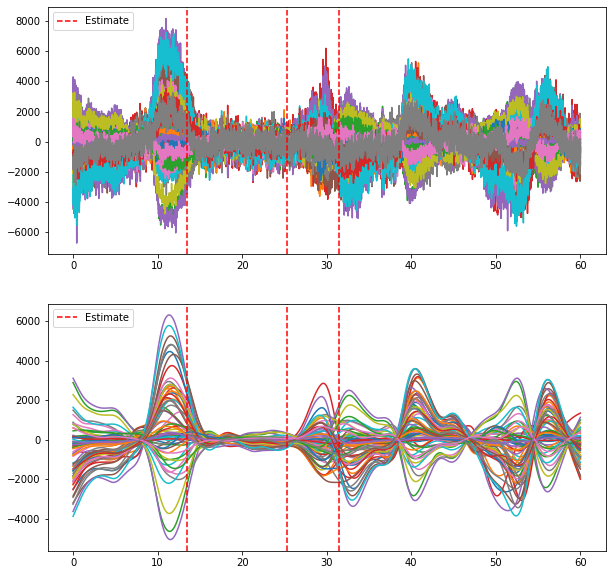

In [73]:
# 15, 32, 34
adIdx = 15
with open(filsAD[adIdx], "rb") as f:
    detAD = pickle.load(f)
detAD.UpdateEcpts(detAD.numchgs[kps==optKp][0])
plotRes(detAD, fname=f"./plots/exampleAD{adIdx}.jpg")

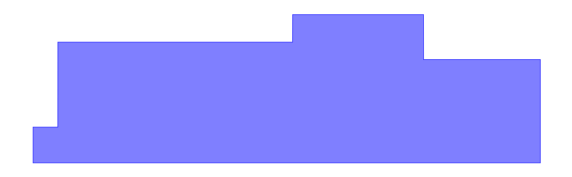

In [69]:
adIdx = 34
with open(filsAD[adIdx], "rb") as f:
    detAD = pickle.load(f)
detAD.UpdateEcpts(detAD.numchgs[kps==optKp][0])
vec = np.abs(detAD.RecResCur.LamMs)[0, :]
xs = list(range(len(vec)))
low = np.zeros_like(vec)+7
plt.figure(figsize=[10, 3])
plt.fill_between(xs, low, vec,  color="blue", alpha=.5)
plt.xticks([])
plt.yticks([])
plt.box(0)
plt.savefig(f"./plots/exampleW1.jpg", bbox_inches='tight')

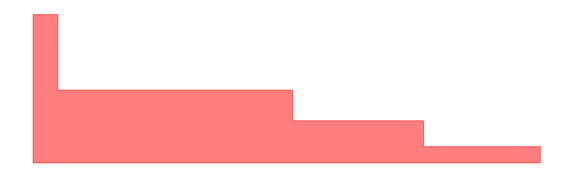

In [70]:
vec = np.abs(detAD.RecResCur.LamMs)[2, :]
xs = list(range(len(vec)))
low = np.zeros_like(vec)
plt.figure(figsize=[10, 3])
plt.fill_between(xs, low, vec,  color="red", alpha=.5)
plt.xticks([])
plt.yticks([])
plt.box(0)
plt.savefig(f"./plots/exampleW2.jpg", bbox_inches='tight')

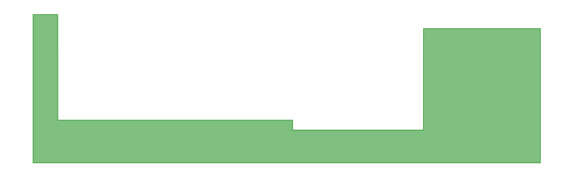

In [71]:
vec = np.abs(detAD.RecResCur.LamMs)[4, :]
xs = list(range(len(vec)))
low = np.zeros_like(vec)
plt.figure(figsize=[10, 3])
plt.fill_between(xs, low, vec,  color="green", alpha=.5)
plt.xticks([])
plt.yticks([])
plt.box(0)
plt.savefig(f"./plots/exampleW3.jpg", bbox_inches='tight')